In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
data_csv = pd.read_csv('/Users/stardust/data/seaborn-data/flights.csv',usecols=[2])
data_csv

,passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


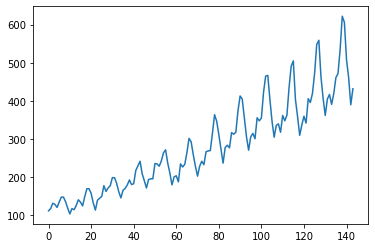

In [33]:
plt.plot(data_csv)

In [34]:
# 数据预处理
data_csv = data_csv.dropna()  # 滤除缺失数据
dataset = data_csv.values   # 获得csv的值
dataset = dataset.astype('float32')
max_value = np.max(dataset)  # 获得最大值
min_value = np.min(dataset)  # 获得最小值
scalar = max_value - min_value  # 获得间隔数量
dataset = list(map(lambda x: x / scalar, dataset)) # 归一化

In [35]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [49]:
data_X.shape,data_X[:3],data_Y.shape,data_Y[:3]

(torch.Size([142, 1, 2]),
 tensor([[[0.2162, 0.2278]],
 
         [[0.2278, 0.2548]],
 
         [[0.2548, 0.2490]]]),
 (142, 1),
 array([[0.25482625],
        [0.24903475],
        [0.23359074]], dtype=float32))

In [36]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [37]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [63]:
train_X.shape,train_X[:3],train_Y.shape,train_Y[:3]

((99, 1, 2),
 array([[[0.21621622, 0.22779922]],
 
        [[0.22779922, 0.25482625]],
 
        [[0.25482625, 0.24903475]]], dtype=float32),
 (99, 1, 1),
 array([[[0.25482625]],
 
        [[0.24903475]],
 
        [[0.23359074]]], dtype=float32))

In [65]:
from torch import nn
from torch.autograd import Variable

class lstm(nn.Module):
    def __init__(self,input_size=2,hidden_size=4,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

model = lstm(2, 4,1,2)

In [66]:
print(model)

lstm(
  (layer1): LSTM(2, 4, num_layers=2)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)


In [64]:
summary(model,train_X.shape)

RuntimeError: input must have 3 dimensions, got 4

In [39]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [42]:
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00338
Epoch: 200, Loss: 0.00318
Epoch: 300, Loss: 0.00298
Epoch: 400, Loss: 0.00263
Epoch: 500, Loss: 0.00173
Epoch: 600, Loss: 0.00130
Epoch: 700, Loss: 0.00117
Epoch: 800, Loss: 0.00104
Epoch: 900, Loss: 0.00156
Epoch: 1000, Loss: 0.00113


In [43]:
model = model.eval() # 转换成测试模式

data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = model(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

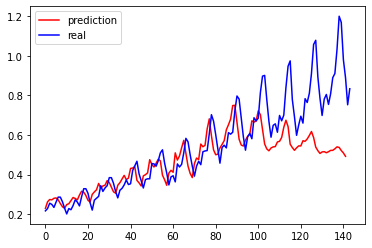

In [44]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')